# クラス

## プログラム：Mandelbrot Set

* 以下はマンデルブロ集合を描画するプログラムである

In [1]:
import cmath

def mandelbrot():
    width, height, step = 100, 30, 1000
    x_min, x_max, y_min, y_max = -2.2, 0.8, -1.25, 1.25

    char_dict = {15: "*", 17: "+", 20: "~", 30: "-", step: ".", (step + 1): " "}

    for i in range(height):
        for j in range(width):
            x = (j + 0.5) * (x_max - x_min) / width + x_min
            y = (i + 0.5) * (y_max - y_min) / height + y_min

            z = 0.0
            step_div = step
            try:
                for k in range(step):
                    z = z ** 2 + complex(x, y)
                    if cmath.isnan(z) or cmath.isinf(z):
                        step_div = k
                        break
            except OverflowError:
                step_div = k

            for k, c in sorted(char_dict.items()):
                if step_div < k:
                    print(c, end="")
                    break
        print()

mandelbrot()

****************************************************************************************************
******************************************************************++********************************
*****************************************************************++--+++++**************************
****************************************************************+++~~--~~++*************************
*************************************************************+++~---. .-~~~+************************
**********************************************************+++++~--       -~+++**********************
***************************************************++++~~++~~~~~--      .-~~~~++++++++**************
*************************************************+++~...-.--. .            .. -~~--~--~+************
***********************************************++++~~--                         .   .-~+************
******************************+++*****+++++++++++~...-                             --~+++**

## クラスを使って書き直す

* クラスを使うと汎用性は高くなるが一般にコード量は増える

### xy平面を表すクラス

In [2]:
class Field:
    def __init__(self, width=80, height=24, x_range=(-1.0, 1.0), y_range=(-1.0, 1.0)):
        self._width = width
        self._height = height
        self._data = [None] * (width * height)
        self.x_range = x_range
        self.y_range = y_range
    
    def width(self):
        return self._width
    
    def height(self):
        return self._height
    
    def ij_to_xy(self, i, j):
        # i: (0:height) -> y: (y_min:y_max)
        # j: (0:width)  -> x: (x_min:x_max)
        x_min, x_max = self.x_range
        y_min, y_max = self.y_range
        x = j * (x_max - x_min) / (self._width  - 1)  + x_min
        y = i * (y_max - y_min) / (self._height - 1) + y_min
        return (x, y)
    
    def _ij_to_index(self, i, j):
        if 0 <= i < self._height and 0 <= j < self._width:
            return i * self._width + j
        else:
            return None
    
    def __getitem__(self, pos):
        if isinstance(pos, int):
            i, w = pos, self._width
            return self._data[i * w : (i + 1) * w]
        i, j = pos
        index = self._ij_to_index(i, j)
        if index != None:
            return self._data[index]
        else:
            s = "(i, j) = ({0}, {1}) but (h, w) = ({2}, {3})"
            raise IndexError(s.format(i, j, self._width, self._height))
    
    def __setitem__(self, pos, value):
        i, j = pos
        index = self._ij_to_index(i, j)
        if index != None:
            self._data[index] = value
        else:
            s = "(i, j) = ({0}, {1}) but (h, w) = ({2}, {3})"
            raise IndexError(s.format(i, j, self._width, self._height))
    
    def __len__(self):
        return self._height
    
    def __iter__(self):
        w = self._width
        return (self._data[i * w : (i + 1) * w] for i in range(self._height))
    
    def ij(self):
        return ((i, j) for i in range(self._height) for j in range(self._width))
    
    def ijxy(self):
        return ((i, j, *self.ij_to_xy(i, j)) for i in range(self._height) for j in range(self._width))

In [23]:
field = Field(5, 5, (-3.0, 3.0), (0.0, 5.0))
for i, j, x, y in field.ijxy():
    field[i, j] = complex(x, y)
for row in field:
    print(" ".join("{: 7.3f}".format(z) for z in row))

 0.000-3.000j  0.000-1.500j  0.000+0.000j  0.000+1.500j  0.000+3.000j
 1.250-3.000j  1.250-1.500j  1.250+0.000j  1.250+1.500j  1.250+3.000j
 2.500-3.000j  2.500-1.500j  2.500+0.000j  2.500+1.500j  2.500+3.000j
 3.750-3.000j  3.750-1.500j  3.750+0.000j  3.750+1.500j  3.750+3.000j
 5.000-3.000j  5.000-1.500j  5.000+0.000j  5.000+1.500j  5.000+3.000j


* `class` でクラスを定義し、以下に `def` と書くことでオブジェクト（インスタンス）のメソッドを定義できる
* `__init__` でオブジェクトを初期化する
* `__getitem__`, `__setitem__` を定義すると `[]` を使ったアクセスができるようになる
* `__len__` を定義するとオブジェクトに対して `len` 関数を使えるようになる
* `__iter__` を定義すると `for` ... `in` 文で回したりすることができる

### xy平面をテキストで描画するクラス

In [4]:
class FieldPrinter:
    def print(self, field):
        raise Exception("unimplemented")
    
class TextFieldPrinter(FieldPrinter):
    def __init__(self, step=1000, char_dict=None):
        self.step = step
        if char_dict:
            self.char_dict = char_dict
        else:
            self.char_dict = {15: "*", 17: "+", 20: "~", 30: "-", step: ".", step + 1: " "}
        self.step_char_list = sorted(self.char_dict.items())
    
    def print(self, field):
        for row in reversed(field):
            for step_div in row:
                print_flag = False
                for k, c in self.step_char_list:
                    if step_div < k:
                        print(c, end="")
                        print_flag = True
                        break
                if not print_flag:
                    print(self.step_char_list[-1][1], end="")
            print()

* `TextFieldPrinter` クラスを `FieldPrinter` クラスの派生クラスとして定義している

In [5]:
field = Field(21, 11, (-10, 10), (-10, 10))
for i, j, x, y in field.ijxy():
    field[i, j] = abs(x * y)
TextFieldPrinter(step=70).print(field)

    ....-***-....    
  .....-+***+-.....  
......-~*****~-......
...---+*******+---...
-~+***************+~-
*********************
-~+***************+~-
...---+*******+---...
......-~*****~-......
  .....-+***+-.....  
    ....-***-....    


### マンデルブロ集合の計算を行うクラス

In [6]:
import cmath

class ComplexDynamicalSystem:
    def __init__(self, step=1000):
        self.step = step
    
    def calc(self, x, y):
        raise Exception("unimplemented")

class Mandelbrot(ComplexDynamicalSystem):
    def calc(self, x, y):
        c = complex(x, y)
        z = 0.0
        step_div = self.step
        try:
            for k in range(self.step):
                z = z ** 2 + c
                if cmath.isnan(z) or cmath.isinf(z):
                    step_div = k
                    break
        except OverflowError:
                step_div = k
        return step_div

* `Mandelbrot` クラスを `ComplexDynamicalSystem` クラスの派生クラスとして定義している
* 各 $(x, y)$ について漸化式 $z_{n} = z_{n - 1}^2 + x + yi,\ (z_{0} = 0)$ が発散するかどうかを調べる
    * 実際には「値が `nan`/`inf` になった／オーバーフローした時の $n$ (`step_div`)」を返すメソッドとして定義している

### アプリケーションクラス

In [7]:
class ComplexDynamics:
    def __init__(self, field, system, printer=None):
        self.field = field
        self.system = system
        if printer:
            self.printer = printer
        else:
            self.printer = TextFieldPrinter(system.step)
    
    def calc(self):
        for i, j, x, y in self.field.ijxy():
            self.field[i, j] = self.system.calc(x, y)
    
    def print(self):
        self.printer.print(self.field)

In [8]:
f = Field(100, 30, (-2.2, 0.8), (-1.25, 1.25))
m = ComplexDynamics(f, Mandelbrot())
m.calc()
m.print()

****************************************************************************************************
****************************************************************************************************
*****************************************************************+~-++******************************
****************************************************************+++~.-~-~+**************************
**************************************************************+++~~--.--~++*************************
***********************************************************++++~-..    .--~++***********************
****************************************************+++++++++~~~-.      .-~~++++++******************
**************************************************++~-.---~-......      . ..-.-~~~~~.~+*************
***********************************************++++~~-.   .                    .-   .-~+************
******************************************+++++++~-.--                            .-~~++***

In [9]:
f = Field(x_range=(-0.5, 0.2), y_range=(0.5, 1.0))
m = ComplexDynamics(f, Mandelbrot())
m.calc()
m.print()

***************************++++++++~~~~-----~~~~~-~---.--~++********************
**************************+++++++++~~~~~-.-.---...----~~+++++*******************
************************++++++++++~~~~~~~----.----~~~~~+++++++******************
**********************+++++++++++~~~~~~~---.-.---~~~~~~++++++++*****************
*******************+++++++++++~~~~~~~~-.----..-----~~~~~++++++++****************
*****************++++++++++~~~~~~~~~-..-.... ..--.--~~~~~~++++++++**************
***************++++++++~~~~~-..--------...     .-----~~~~~~-~++++++*************
*************++++++++~~-.-.....-----......    ..---.-----...~~+++++++***********
**********+++++++++++~~~------ ......            ...----...-~~~+++++++**********
*******++++++++++++++~~~~~~---..  .                ......----~~+++++++++********
*+++++++++++++++++++~~~~~~-----..                     ..---~~~~~+++++++++++*****
+++++++++++++++++++~~~~~~--.....                      .-..--~~~~+++++++++++++++*
++++++++++++++++~~~~~~~~~---

### xy平面を画像として描画するクラス

* matplotlib（詳細は後の章で述べる）を使って画像を出力する

In [13]:
# Jupyter Notebook 上で動かす場合のみ必要
%matplotlib inline

In [14]:
import matplotlib.pyplot as plt
import numpy as np

In [15]:
class PlotFieldPrinter(FieldPrinter):
    def __init__(self, cmap='gist_stern'):
        super().__init__()
        self.cmap = cmap
    
    def print(self, field):
        a = np.zeros((field.height(), field.width()))
        for i, row in enumerate(field):
            a[i, :] = row
        plt.imshow(a, interpolation="none", origin='lower', extent=[*field.x_range, *field.y_range],
                   cmap = self.cmap)
        plt.colorbar()

* `PlotFieldPrinter` クラスは `FieldPrinter` クラスを継承している

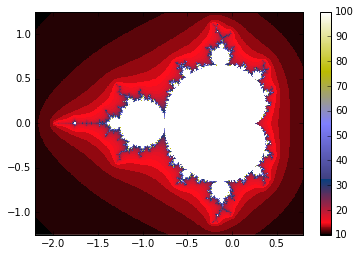

In [16]:
f = Field(640, 480, (-2.2, 0.8), (-1.25, 1.25))
m = ComplexDynamics(f, Mandelbrot(step=100), printer=PlotFieldPrinter())
m.calc()
m.print()

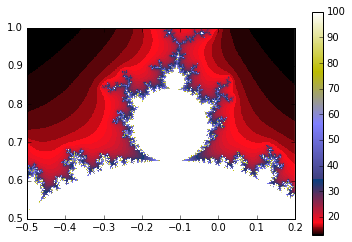

In [17]:
f = Field(640, 480, (-0.5, 0.2), (0.5, 1.0))
m = ComplexDynamics(f, Mandelbrot(step=100), printer=PlotFieldPrinter())
m.calc()
m.print()

### ジュリア集合の計算を行うクラス

In [18]:
class Julia(ComplexDynamicalSystem):
    def __init__(self, step=1000, f=lambda z: z**2, c=-0.4 + 0.6j):
        super().__init__(step)
        self.f = f
        self.c = c
    
    def calc(self, x, y):
        z = complex(x, y)
        step_div = self.step
        try:
            for k in range(self.step):
                z = self.f(z) + self.c
                if cmath.isnan(z) or cmath.isinf(z):
                    step_div = k
                    break
        except OverflowError:
                step_div = k
        return step_div

* `ComplexDynamicalSystem` を継承した `Julia` クラスを定義し、ジュリア集合を描画する

In [19]:
f = Field(45, 15, (-1.5, 1.5), (-1.0, 1.0))
m = ComplexDynamics(f, Julia(step=100))
m.calc()
m.print()

*********************************************
******************+~..~**********************
*******..+**+~.-+~~.. .~*********************
*****~-....-.-..... .-~++********************
***.....  ....     . . ..+*******************
****++~ ..-.. .    .. ...~+++++.*************
*******-+++ ....... ....-. --.  .************
***********+~-.................-~+***********
************.  .-- .-.... ....... +++-*******
*************.+++++~... ..    . ..-.. ~++****
*******************+.. . .     ....  .....***
********************++~-. .....-.-....-~*****
*********************~. ..~~+-.~+**+..*******
**********************~..~+******************
*********************************************


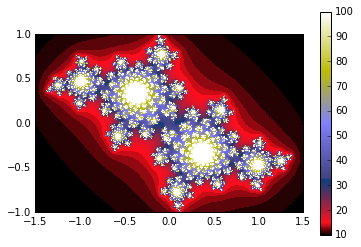

In [20]:
f = Field(640, 480, (-1.5, 1.5), (-1.0, 1.0))
m = ComplexDynamics(f, Julia(step=100), printer=PlotFieldPrinter())
m.calc()
m.print()

In [21]:
f = Field(45, 15, (-1.5, 1.5), (-1.0, 1.0))
m = ComplexDynamics(f, Julia(step=40, f=lambda z:cmath.exp(z**3), c=-0.59))
m.calc()
m.print()

********************--*-----*-*-- *---***-*-*
-*****************---** --*--*-*-- *--**-.+* 
* .--.****-*-*+*+*------*********- -- *-*****
***--+***+~-*.-*-*-- -..*--*-*-**-.+*+*******
*--*---~+-.*--*-. ~--.---*****-*-*- +********
*--*-...-.*---* -..-*---*---.*. *---*********
**-*--*--*-*-*-.-*---*-*-*-... .-** --*******
*********************************************
**-*--*--*-*-*-.-*---*-*-*-... .-** --*******
*--*-...-.*---* -..-*---*---.*. *---*********
*--*---~+-.*--*-. ~--.---*****-*-*- +********
***--+***+~-*.-*-*-- -..*--*-*-**-.+*+*******
* .--.****-*-*+*+*------*********- -- *-*****
-*****************---** --*--*-*-- *--**-.+* 
********************--*-----*-*-- *---***-*-*


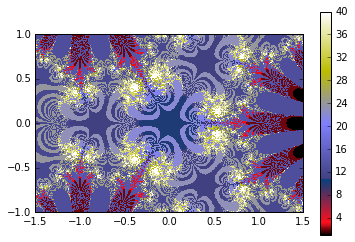

In [22]:
f = Field(640, 480, (-1.5, 1.5), (-1.0, 1.0))
m = ComplexDynamics(f, Julia(step=40, f=lambda z:cmath.exp(z**3), c=-0.59), printer=PlotFieldPrinter())
m.calc()
m.print()